# Imports and settings

In [1]:
import itertools
import os
import json
import pickle
import glob
import warnings

import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin
import statsmodels

from utils import (
    BIDS_ROOT,
    get_erps_by_dict,
    dict2arr,
    get_model_rdm,
    find_time_idxs,
)
from clusterperm import return_observed_clusters, evaluate_significance

In [2]:
# settings

plotdir = os.path.join(BIDS_ROOT, "code", "publication_plots")

for directory in [plotdir]:
    os.makedirs(directory, exist_ok=True)

dina4_width_inch = 8.27

# General settings

In [5]:
# settings
plotting_context = dict(context="talk", font_scale=1)

swarmsize = 2  # for strip and swarmplot how big the dots

ci = 68  # the error bars, 68 ~ SEM

axhline_args = dict(color="black", linestyle="--", linewidth=1)

pointdodge = 0.2  # for pointplot, how much means dodge
pointscale = 3
pointmarkers = "."  # for pointplot which marker style
pointerrwidth = 3
pointlinewidth = axhline_args["linewidth"]
pointcapwidth = 0.1

labelpad = 12

sampling_order = ["active", "yoked"]
stopping_order = ["fixed", "variable"]

subj_line_settings = dict(color="black", alpha=0.1, linewidth=0.75)

panel_letter_kwargs = dict(
    x=-0.2,
    y=1.15,
    horizontalalignment="center",
    verticalalignment="center",
)

# Figure 1

## start

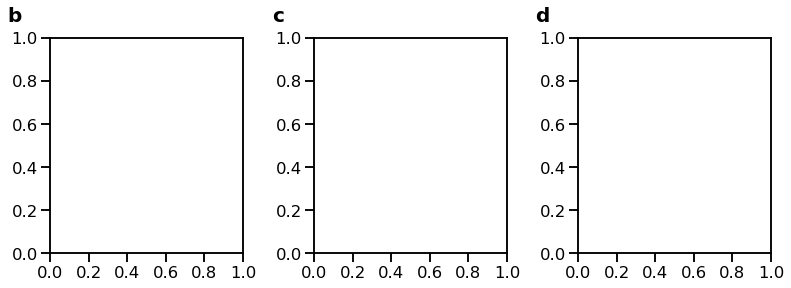

In [6]:
# start new figure
with sns.plotting_context(**plotting_context):
    fig, axs = plt.subplots(
        1, 3, figsize=(dina4_width_inch + 3, 4), gridspec_kw={"width_ratios": [3, 3, 3]}
    )
    fig.tight_layout()

    # plot panel letters
    # see: https://gitter.im/matplotlib/matplotlib?at=5fb53257c6fe0131d40227bb
    for ax, label in zip(axs.flat, (i for i in "bcd")):

        x = -0.5
        y = 0.3
        offset = transforms.ScaledTranslation(x, y, fig.dpi_scale_trans)
        transform = ax.transAxes + offset

        ax.text(
            s=label,
            x=0,
            y=1,
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=plt.rcParams["font.size"] + 2,
            transform=transform,
        )

## panel 1

In [7]:
# load data
fname = "beh_accuracies.csv"
fname = os.path.join(plotdir, fname)

beh_accuracies = pd.read_csv(fname)

for factor in ["sampling", "stopping"]:
    beh_accuracies[factor] = beh_accuracies[factor].str.lower()

beh_accuracies["accuracy"] = beh_accuracies["correct_choice"].to_numpy()

# plot
with sns.plotting_context(**plotting_context):

    x = "sampling"
    order = sampling_order
    y = "accuracy"
    hue = "stopping"
    hue_order = stopping_order
    ax = axs[0]

    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        sns.pointplot(
            x=x,
            order=order,
            y=y,
            hue=hue,
            hue_order=hue_order,
            data=beh_accuracies,
            ci=ci,
            dodge=pointdodge,
            ax=ax,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    sns.swarmplot(
        x=x,
        order=order,
        y=y,
        hue=hue,
        hue_order=hue_order,
        data=beh_accuracies,
        ax=ax,
        dodge=pointdodge,
        size=swarmsize,
    )

    ax.get_legend().remove()
    ax.set_xlabel("")  # "Sampling"

    # connect subj dots with lines
    # https://stackoverflow.com/a/51157346/5201771
    if pointdodge:
        _idxs_to_pick = [(2, 4), (3, 5)]
    else:
        _idxs_to_pick = [(2, 3)]
    for idx0, idx1 in _idxs_to_pick:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, **subj_line_settings)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xticklabels(["self-\ncontrolled", "yoked"])

## panel 2

In [8]:
# load data
fname = "decision_weights_logreg_tasks.csv"
fname = os.path.join(plotdir, fname)

decision_weights = pd.read_csv(fname)

# plot
with sns.plotting_context(**plotting_context):

    x = "timing"
    y = "slope"

    # cannot pass order to lineplot, so sanity check data
    order = ["early", "mid", "late"]
    assert decision_weights["timing"][0:3].to_list() == order

    hue = "stopping"
    hue_order = stopping_order
    style = "sampling"
    style_order = sampling_order
    ax = axs[1]

    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        sns.lineplot(
            x="timing",
            y="slope",
            hue="stopping",
            hue_order=hue_order,
            style=style,
            style_order=style_order,
            data=decision_weights,
            ci=68,
            ax=ax,
            legend=False,
            palette={
                "variable": sns.color_palette()[1],
                "fixed": sns.color_palette()[0],
            },
        )

    ax.axhline(0, **axhline_args)
    ax.set_ylabel("decision weight")
    ax.set_xlabel("")  # "sample position"

    with sns.plotting_context(
        context=plotting_context["context"],
        font_scale=plotting_context["font_scale"] - 0.2,
    ):
        _text = ax.text(
            x=0.5,
            y=0.9,
            s="sample position",
            ha="center",
            transform=ax.transAxes,
        )

    # add legend
    # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
    legend_elements = []
    for linestyle in ["-", "--"]:
        for i, label in enumerate(["partial control", "full control"]):

            if linestyle == "--":
                label = "yoked"

            color = sns.color_palette()[i]
            legend_elements.append(
                Line2D(
                    [0], [0], color=color, marker=None, label=label, linestyle=linestyle
                ),
            )

    legend = fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.05),
        framealpha=1,
        frameon=False,
        ncol=2,
        title="",  # "Sampling"
    )

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## panel 3

In [9]:
# Load data
fname = "beh_recency_logreg.csv"
fname = os.path.join(plotdir, fname)

beh_recency = pd.read_csv(fname)

for factor in ["sampling", "stopping"]:
    beh_recency[factor] = beh_recency[factor].str.lower()

# reconstruct variables from df
potential_colnames = [col for col in beh_recency.columns if col.startswith("slope_")]
colname = [col for col in potential_colnames if "_minus_" in col][0]
first = colname.split("_")[1]
second = colname.split("_")[3]


# plot
with sns.plotting_context(**plotting_context):

    ax = axs.flat[2]
    x = "sampling"
    order = sampling_order
    hue = "stopping"
    hue_order = stopping_order

    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        sns.pointplot(
            x=x,
            order=order,
            y=colname,
            hue=hue,
            hue_order=hue_order,
            data=beh_recency,
            dodge=pointdodge,
            ci=ci,
            ax=ax,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    sns.swarmplot(
        x=x,
        order=order,
        y=colname,
        hue=hue,
        hue_order=hue_order,
        data=beh_recency,
        ax=ax,
        dodge=pointdodge,
        size=swarmsize,
    )

    ax.axhline(0, **axhline_args)

    ax.set_xlabel("")  # "Sampling"
    ax.set_ylabel(f"{first} - {second}")
    ax.get_legend().remove()

    # connect subj dots with lines
    # https://stackoverflow.com/a/51157346/5201771
    if pointdodge:
        _idxs_to_pick = [(2, 4), (3, 5)]
    else:
        _idxs_to_pick = [(2, 3)]
    for idx0, idx1 in _idxs_to_pick:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, **subj_line_settings)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xticklabels(["self-\ncontrolled", "yoked"])

## tweaks

In [10]:
# make 1c y axis a bit larger than need be
# so that 1c does not visually dominate
ylims = axs.flat[1].get_ylim()
axs.flat[1].set_ylim(ylims[0], ylims[1] * 1.2)

(-0.0174354736150098, 0.43937393509824674)

In [11]:
# make sure "zero line" is aligned between 1c and 1d
# see: https://stackoverflow.com/a/65824524/5201771
ax1 = axs.flat[1]
ax2 = axs.flat[-1]

ax1_ylims = ax1.axes.get_ylim()
ax1_yratio = ax1_ylims[0] / ax1_ylims[1]

ax2_ylims = ax2.axes.get_ylim()
ax2_yratio = ax2_ylims[0] / ax2_ylims[1]

if ax1_yratio < ax2_yratio:
    ax2.set_ylim(bottom=ax2_ylims[1] * ax1_yratio)
else:
    ax1.set_ylim(bottom=ax1_ylims[1] * ax2_yratio)

In [12]:
# to make the xticks "narrower" / squeeze them horizontally
# at the expense of having whitespace
ax = axs.flat[1]
ax.set_xlim(-0.6, 2.7)

# same game for the other panels
ax = axs.flat[0]
ax.set_xlim(-0.75, 1.75)

ax = axs.flat[2]
ax.set_xlim(-0.75, 1.75)

(-0.75, 1.75)

## finish

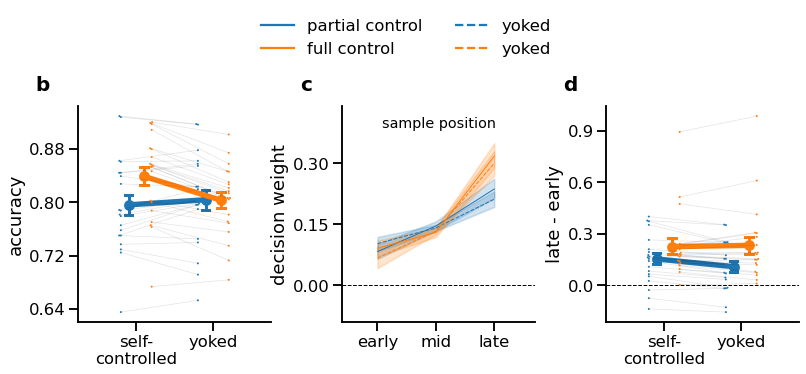

In [13]:
sns.despine(fig)
fig.align_labels()

fname = "fig1bcd.pdf"
fname = os.path.join(plotdir, fname)

fig.savefig(fname, bbox_extra_artists=[legend], bbox_inches="tight")
fig

# Figure 2

## start

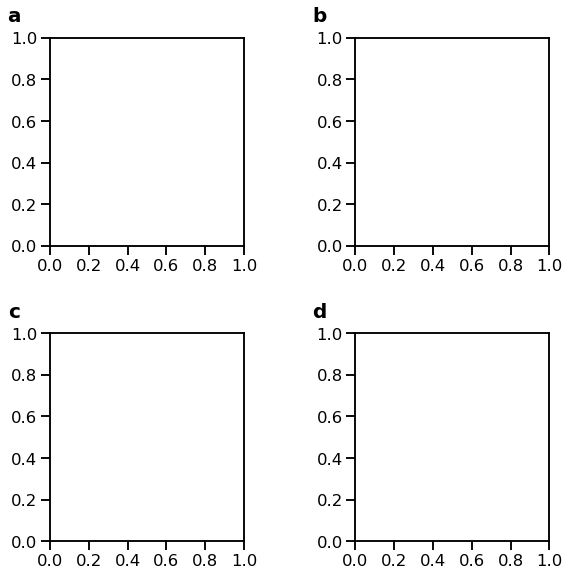

In [77]:
# preprocessing settings
preproc_settings = {
    "crop": (0.6, 1.6),
    "tshift": -0.8,
    "smooth": False,
    "baseline": (None, 0),
}


with sns.plotting_context(**plotting_context):
    # equivalent to: fig, axs = plt.subplots(2, 2, figsize=(dina4_width_inch, 8))
    # ... but allows for sharing y-axis across individual subplots
    fig = plt.figure(figsize=(dina4_width_inch, 8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4, sharey=None)

    axs = np.array(((ax1, ax2), (ax3, ax4)))
    fig.tight_layout(h_pad=3, w_pad=3)


# plot panel letters
# see: https://gitter.im/matplotlib/matplotlib?at=5fb53257c6fe0131d40227bb
with sns.plotting_context(**plotting_context):

    for ax, label in zip(axs.flat, (i for i in "abcd")):

        x = -0.5
        y = 0.3
        offset = transforms.ScaledTranslation(x, y, fig.dpi_scale_trans)
        transform = ax.transAxes + offset

        ax.text(
            s=label,
            x=0,
            y=1,
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=plt.rcParams["font.size"] + 2,
            transform=transform,
        )

In [78]:
# IO: Where to find the data
# Where to find epochs
fname_epo_template = os.path.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_epochs-epo.fif.gz"
)


# Pack all names in a dict
name_templates = dict()
name_templates["epochs"] = fname_epo_template

subjects = range(1, 41)

In [79]:
colors = {"variable": sns.color_palette()[1], "fixed": sns.color_palette()[0]}
linestyles = {"active": "-", "yoked": "--"}

p1_n1_grp = ["O2", "PO4", "PO8", "PO10"]
opo_grp = p1_n1_grp + ["O1", "PO3", "PO7", "PO9"]

p1_window = (0.08, 0.13)
n1_window = (0.14, 0.20)

subtract = ("left", "right")

sampling_styles = ("active", "yoked")
stopping_styles = ("fixed", "variable")

## panel 1

In [80]:
double_subtraction = True

try:
    soverall_erps
    print("Data already loaded")
except NameError:
    soverall_erps = {
        "{0}/{1}".format(*ii): list()
        for ii in itertools.product(sampling_styles, stopping_styles)
    }
    soverall_erps = get_erps_by_dict(
        soverall_erps,
        name_templates,
        subjects,
        subtract=subtract,
        double_subtraction=double_subtraction,
        **preproc_settings
    )

if double_subtraction:
    # if we do a double subtraction, we need an extra dummy ERP to get
    # channel positions
    tmp = get_erps_by_dict({"all": list()}, name_templates, [1], **preproc_settings)
    coord_dummy_erp = tmp["all"][0]

Data already loaded


In [81]:
# obtain an erp data object to access the digitizied electrode positions
# and ch_names, etc
tmperp = soverall_erps["active/fixed"][0].copy()

In [82]:
# convert ERP dict to data frame
soverall_arr = dict2arr(soverall_erps)

# array to data frame
arr = np.column_stack(
    list(map(np.ravel, np.meshgrid(*map(np.arange, soverall_arr.shape), indexing="ij")))
    + [soverall_arr.ravel()]
)
df_soverall = pd.DataFrame(
    arr, columns=["task", "ch_names", "time_s", "subj_repr", "amplitude"]
)

# make data frame pretty
df_soverall["ch_names"] = df_soverall["ch_names"].map(
    dict(zip(range(len(tmperp.ch_names)), tmperp.ch_names))
)
df_soverall["task"] = df_soverall["task"].map(
    dict(zip(range(len(soverall_erps)), list(soverall_erps.keys())))
)
df_soverall["time_s"] = df_soverall["time_s"].map(
    dict(zip(range(len(tmperp.times)), tmperp.times))
)

df_soverall["sampling"] = [i[0] for i in df_soverall["task"].str.split("/")]
df_soverall["stopping"] = [i[1] for i in df_soverall["task"].str.split("/")]

df_soverall["subj_repr"] = df_soverall["subj_repr"].astype(int)

In [83]:
if double_subtraction:
    df_soverall_chsel = df_soverall[df_soverall["ch_names"].isin(["opo"])]
else:
    df_soverall_chsel = df_soverall[df_soverall["ch_names"].isin(p1_n1_grp)]

amps = []
for meta, grp in df_soverall_chsel.groupby("ch_names"):
    amps.append(grp["amplitude"])
amps = np.mean(np.stack(amps), axis=0)

grp["amplitude"] = amps
grp = grp.drop("ch_names", axis=1)
df_soverall_chsel = grp.copy()
df_soverall_chsel

,task,time_s,subj_repr,amplitude,sampling,stopping
0,active/fixed,-0.2,0,0.037314,active,fixed
1,active/fixed,-0.2,1,0.111929,active,fixed
2,active/fixed,-0.2,2,-0.966445,active,fixed
3,active/fixed,-0.2,3,0.124465,active,fixed
4,active/fixed,-0.2,4,0.938254,active,fixed
...,...,...,...,...,...,...
20075,yoked/variable,0.8,15,-0.984496,yoked,variable
20076,yoked/variable,0.8,16,0.401327,yoked,variable
20077,yoked/variable,0.8,17,3.364581,yoked,variable
20078,yoked/variable,0.8,18,-1.193200,yoked,variable


In [84]:
ax = axs.flat[0]

with sns.plotting_context(**plotting_context):

    hue_order = stopping_order

    sns.lineplot(
        x="time_s",
        y="amplitude",
        data=df_soverall_chsel,
        hue="stopping",
        hue_order=hue_order,
        style="sampling",
        ax=ax,
        ci=ci,
        legend=False,
    )

    # make ylims symmetric
    maxylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim((-maxylim, maxylim))

    # plot the selected electrodes
    axins = inset_axes(ax, width="30%", height="30%", loc="upper left")

    if double_subtraction:
        coord_dummy_erp.copy().pick_channels(opo_grp).plot_sensors(
            kind="topomap", title="", axes=axins, show=False
        )
    else:
        tmperp.copy().pick_channels(p1_n1_grp).plot_sensors(
            kind="topomap", title="", axes=axins, show=False
        )
    axins.collections[0].set_sizes([1])

    # Plot Zero lines
    ax.axhline(0, linestyle="--", color="black", linewidth=0.75)
    ax.axvline(0, ymax=0.69, linestyle="--", color="black", linewidth=0.75)

    ax.set_xlabel("time (s)")
    ax.set_ylabel("left - right (µV)\n(double subtraction)")


# plot gray shadings
ax.axvspan(*p1_window, ymin=0.5, ymax=1.0, color="black", alpha=0.1)
ax.axvspan(*n1_window, ymin=0.0, ymax=0.5, color="black", alpha=0.1)

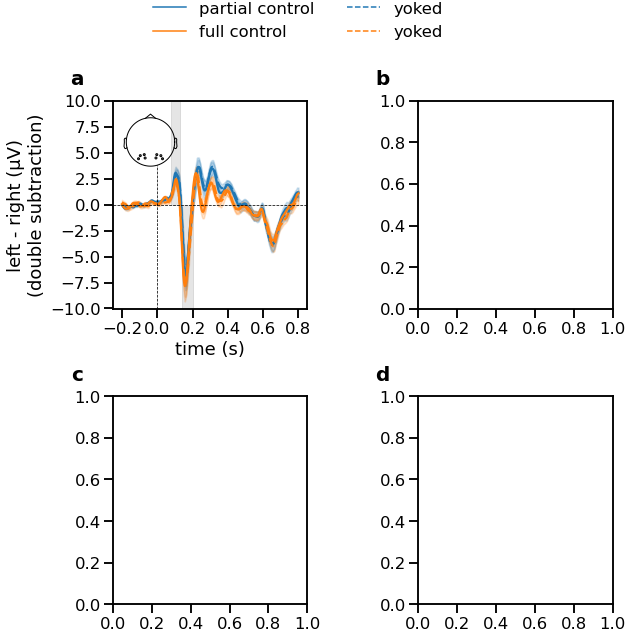

In [85]:
# get the correct orderings in plotting
# NOTE: pd.unique provides in the order "as found"
stopping_order = list(pd.unique(df_soverall_chsel["stopping"]))
sampling_order = list(pd.unique(df_soverall_chsel["sampling"]))

# The following legend is encoded according to these assumptions:
assert stopping_order == hue_order
assert sampling_order == ["active", "yoked"]

# add legend
# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = []
for linestyle in ["-", "--"]:
    for i, label in enumerate(["partial control", "full control"]):

        if linestyle == "--":
            label = "yoked"

        color = sns.color_palette()[i]
        legend_elements.append(
            Line2D(
                [0], [0], color=color, marker=None, label=label, linestyle=linestyle
            ),
        )

# define invisible bogus item to tweak legend
bogus_item = Line2D([0], [0], color="white", marker=None, label="", linestyle=linestyle)
legend_elements.insert(2, bogus_item)


with sns.plotting_context(**plotting_context):
    ax = axs.flat[0]

    legend1 = fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.975),
        framealpha=1,
        frameon=False,
        ncol=2,
        title="",  # "sampling"
    )

sns.despine(ax=ax)
fig

## panel 2

In [86]:
p3_grp = ["Cz", "C1", "C2", "CPz", "CP1", "CP2", "CP3", "CP4", "Pz", "P1", "P2"]

p3_window = (0.3, 0.6)

In [87]:
timings = ("early", "mid", "late")

In [88]:
fname = "eeg_accumulation.csv"
fname = os.path.join(plotdir, fname)

eeg_accumulation = pd.read_csv(fname)
colname = "mean_amp_diff_late_minus_early"
assert eeg_accumulation.columns[-1] == colname

# make sampling and stopping levels lowercase
eeg_accumulation["sampling"] = eeg_accumulation["sampling"].str.lower()
eeg_accumulation["stopping"] = eeg_accumulation["stopping"].str.lower()

In [89]:
eeg_accumulation = eeg_accumulation.sort_values(by=["subject"])
eeg_accumulation.head()

,subject,sampling,stopping,mean_amp_diff_late_minus_early
0,1,active,fixed,-0.213429
40,1,yoked,fixed,0.700574
20,2,active,variable,1.279451
60,2,yoked,variable,-1.617618
1,3,active,fixed,1.127872


In [90]:
eeg_acc_full = eeg_accumulation[
    (eeg_accumulation["sampling"] == "active")
    & (eeg_accumulation["stopping"] == "variable")
]

eeg_acc_partial = eeg_accumulation[
    (eeg_accumulation["sampling"] == "active")
    & (eeg_accumulation["stopping"] == "fixed")
]

In [91]:
with sns.plotting_context(**plotting_context):
    ax = axs.flat[1]

    x = "sampling"
    order = sampling_order
    hue = "stopping"
    hue_order = stopping_order

    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        sns.pointplot(
            x=x,
            order=order,
            y=colname,
            hue=hue,
            hue_order=hue_order,
            data=eeg_accumulation,
            dodge=pointdodge,
            ci=ci,
            ax=ax,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    sns.swarmplot(
        x=x,
        order=order,
        y=colname,
        hue=hue,
        hue_order=hue_order,
        data=eeg_accumulation,
        ax=ax,
        dodge=True,
        size=swarmsize,
    )

    # connect subj dots
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, **subj_line_settings)

    # make ylims symmetric
    # maxylim = np.abs(ax.get_ylim()).max()
    # ax.set_ylim((-maxylim, maxylim))
    ax.set_ylim(None, 5)

    # plot axins
    # plot the selected electrodes
    _ = get_erps_by_dict({"all": list()}, name_templates, [1], **preproc_settings)[
        "all"
    ][0]

    axins = inset_axes(
        ax,
        width="30%",
        height="30%",
        loc="upper left",
    )

    _.copy().pick_channels(p3_grp).plot_sensors(
        kind="topomap", title="", axes=axins, show=False
    )
    axins.collections[0].set_sizes([1])

    # Plot Zero lines
    ax.axhline(0, linestyle="--", color="black", linewidth=0.75)

    # remove unnecessary legend
    ax.get_legend().remove()

    ax.set_xticklabels(["self-\ncontrolled", "yoked"])
    ax.set_xlabel("")
    ax.set_ylabel("late - early samples (µV)")
    assert colname.endswith("late_minus_early")


sns.despine(ax=ax)

## panel 3

In [92]:
try:
    eml_partial
    print("Data already loaded")
except NameError:
    eml_partial = {"active/fixed/{0}".format(ii): list() for ii in timings}
    eml_partial = get_erps_by_dict(
        eml_partial, name_templates, subjects, **preproc_settings
    )

Data already loaded


In [93]:
# obtain an erp data object to access the digitizied electrode positions
# and ch_names, etc
tmperp = eml_partial["active/fixed/early"][0].copy()

In [94]:
# convert ERP dict to data frame
eml_partial_arr = dict2arr(eml_partial)

# array to data frame
arr = np.column_stack(
    list(
        map(
            np.ravel, np.meshgrid(*map(np.arange, eml_partial_arr.shape), indexing="ij")
        )
    )
    + [eml_partial_arr.ravel()]
)
df_eml_partial = pd.DataFrame(
    arr, columns=["timing", "ch_names", "time_s", "subj_repr", "amplitude"]
)


# make data frame pretty
df_eml_partial["ch_names"] = df_eml_partial["ch_names"].map(
    dict(zip(range(len(tmperp.ch_names)), tmperp.ch_names))
)
df_eml_partial["timing"] = df_eml_partial["timing"].map(
    dict(zip(range(len(eml_partial)), list(eml_partial.keys())))
)
df_eml_partial["time_s"] = df_eml_partial["time_s"].map(
    dict(zip(range(len(tmperp.times)), tmperp.times))
)

df_eml_partial["subj_repr"] = df_eml_partial["subj_repr"].astype(int)

In [95]:
df_eml_partial_chsel = df_eml_partial[df_eml_partial["ch_names"].isin(p3_grp)]
amps = []
for meta, grp in df_eml_partial_chsel.groupby("ch_names"):
    amps.append(grp["amplitude"])
amps = np.mean(np.stack(amps), axis=0)

grp["amplitude"] = amps
grp = grp.drop("ch_names", axis=1)
df_eml_partial_chsel = grp.copy()
df_eml_partial_chsel

,timing,time_s,subj_repr,amplitude
120480,active/fixed/early,-0.2,0,0.231732
120481,active/fixed/early,-0.2,1,-0.253122
120482,active/fixed/early,-0.2,2,-0.041831
120483,active/fixed/early,-0.2,3,0.621502
120484,active/fixed/early,-0.2,4,0.556562
...,...,...,...,...
768055,active/fixed/late,0.8,15,-0.471122
768056,active/fixed/late,0.8,16,1.607798
768057,active/fixed/late,0.8,17,0.377974
768058,active/fixed/late,0.8,18,1.416961


In [96]:
with sns.plotting_context(**plotting_context):
    ax = axs.flat[2]

    sns.lineplot(
        x="time_s",
        y="amplitude",
        data=df_eml_partial_chsel,
        hue="timing",
        palette="crest_r",
        ax=ax,
        ci=ci,
        legend=False,
    )

    # make ylims symmetric
    maxylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim((-maxylim, maxylim))

    # plot the selected electrodes
    axins = inset_axes(ax, width="30%", height="30%", loc="upper left")
    tmperp.copy().pick_channels(p3_grp).plot_sensors(
        kind="topomap", title="", axes=axins, show=False
    )
    axins.collections[0].set_sizes([1])

    # Plot Zero lines
    ax.axhline(0, linestyle="--", color="black", linewidth=0.75)
    ax.axvline(0, ymax=0.69, linestyle="--", color="black", linewidth=0.75)

    # plot P3 window span
    ax.axvspan(*p3_window, color="black", alpha=0.1)

    ax.set_xlabel("time (s)")
    ax.set_ylabel("amplitude (µV)")

sns.despine(ax=ax)

In [97]:
# get the correct orderings in plotting
# NOTE: pd.unique provides in the order "as found"
timing_order = list(pd.unique(df_eml_partial_chsel["timing"]))

if timing_order[0].startswith("active"):
    timing_order = [t.split("/")[-1] for t in timing_order]

# The following legend is encoded according to these assumptions:
assert tuple(timing_order) == timings

# add legend
legend_elements = []
for i, label in enumerate(timings):

    color = sns.color_palette("crest_r", n_colors=3)[i]
    legend_elements.append(
        Line2D(
            [0],
            [0],
            color=color,
            marker=None,
            label=label,
        ),
    )


ax = axs.flat[2]

with sns.plotting_context(
    context=plotting_context["context"], font_scale=plotting_context["font_scale"] - 0.2
):
    legend = fig.legend(
        handles=legend_elements[::-1],
        loc="lower right",
        bbox_to_anchor=(1.2, -0.05),
        bbox_transform=ax.axes.transAxes,
        framealpha=1,
        frameon=False,
        ncol=1,
        title="sample position",
    )

## panel 4

In [98]:
try:
    early_mid_late_erps
    print("Data already loaded")
except NameError:
    early_mid_late_erps = {"active/variable/{0}".format(ii): list() for ii in timings}
    early_mid_late_erps = get_erps_by_dict(
        early_mid_late_erps, name_templates, subjects, **preproc_settings
    )

Data already loaded


In [99]:
# convert ERP dict to data frame
eml_arr = dict2arr(early_mid_late_erps)

# array to data frame
arr = np.column_stack(
    list(map(np.ravel, np.meshgrid(*map(np.arange, eml_arr.shape), indexing="ij")))
    + [eml_arr.ravel()]
)
df_eml = pd.DataFrame(
    arr, columns=["timing", "ch_names", "time_s", "subj_repr", "amplitude"]
)

# make data frame pretty
df_eml["ch_names"] = df_eml["ch_names"].map(
    dict(zip(range(len(tmperp.ch_names)), tmperp.ch_names))
)
df_eml["timing"] = df_eml["timing"].map(
    dict(zip(range(len(early_mid_late_erps)), list(early_mid_late_erps.keys())))
)
df_eml["time_s"] = df_eml["time_s"].map(
    dict(zip(range(len(tmperp.times)), tmperp.times))
)

df_eml["subj_repr"] = df_eml["subj_repr"].astype(int)

In [100]:
df_eml_chsel = df_eml[df_eml["ch_names"].isin(p3_grp)]
amps = []
for meta, grp in df_eml_chsel.groupby("ch_names"):
    amps.append(grp["amplitude"])
amps = np.mean(np.stack(amps), axis=0)

grp["amplitude"] = amps
grp = grp.drop("ch_names", axis=1)
df_eml_chsel = grp.copy()
df_eml_chsel

,timing,time_s,subj_repr,amplitude
120480,active/variable/early,-0.2,0,-0.013606
120481,active/variable/early,-0.2,1,0.663329
120482,active/variable/early,-0.2,2,-0.487052
120483,active/variable/early,-0.2,3,0.498022
120484,active/variable/early,-0.2,4,-0.031352
...,...,...,...,...
768055,active/variable/late,0.8,15,3.598040
768056,active/variable/late,0.8,16,2.320941
768057,active/variable/late,0.8,17,1.531623
768058,active/variable/late,0.8,18,1.812307


In [101]:
with sns.plotting_context(**plotting_context):
    ax = axs.flat[3]

    sns.lineplot(
        x="time_s",
        y="amplitude",
        data=df_eml_chsel,
        hue="timing",
        palette="crest_r",
        ax=ax,
        ci=ci,
        legend=False,
    )

    # make ylims symmetric
    maxylim = np.abs(ax.get_ylim()).max()
    ax.set_ylim((-maxylim, maxylim))

    # plot the selected electrodes
    axins = inset_axes(ax, width="30%", height="30%", loc="upper left")
    tmperp.copy().pick_channels(p3_grp).plot_sensors(
        kind="topomap", title="", axes=axins, show=False
    )
    axins.collections[0].set_sizes([1])

    # Plot Zero lines
    ax.axhline(0, linestyle="--", color="black", linewidth=0.75)
    ax.axvline(0, ymax=0.69, linestyle="--", color="black", linewidth=0.75)

    # plot P3 window span
    ax.axvspan(*p3_window, color="black", alpha=0.1)

    ax.set_xlabel("time (s)")
    ax.set_ylabel("amplitude (µV)")

sns.despine(ax=ax)

In [102]:
ax = axs.flat[3]

with sns.plotting_context(
    context=plotting_context["context"], font_scale=plotting_context["font_scale"] - 0.2
):
    legend3 = fig.legend(
        handles=legend_elements[::-1],
        loc="lower right",
        bbox_to_anchor=(1.2, -0.05),
        bbox_transform=ax.axes.transAxes,
        framealpha=1,
        frameon=False,
        ncol=1,
        title="sample position",
    )

## tweaks

In [103]:
# align axes labels
fig.align_ylabels(axs=axs)

In [104]:
# tweak
ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax4.set_ylim(-2.5, 2.5)

with sns.plotting_context(
    context=plotting_context["context"], font_scale=plotting_context["font_scale"] - 0.2
):
    ax2.text(x=0.5, y=1, s="CPP (300-600 ms)", transform=ax2.transAxes, ha="center")
    ax3.text(x=0.5, y=1, s="partial control", transform=ax3.transAxes, ha="center")
    ax4.text(x=0.5, y=1, s="full control", transform=ax4.transAxes, ha="center")

In [105]:
# to make the xticks "narrower" / squeeze them horizontally
# at the expense of having whitespace
ax2.set_xlim(-0.75, 1.75)

(-0.75, 1.75)

## finish

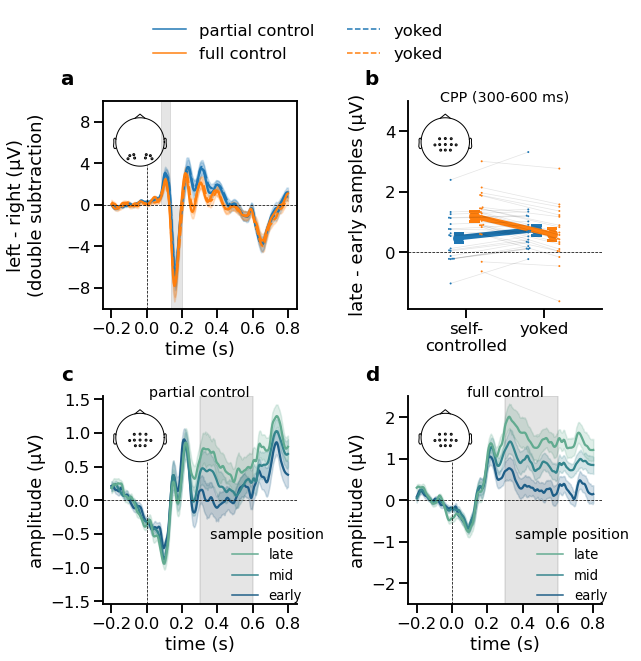

In [106]:
fname = "fig2"
fname = os.path.join(plotdir, fname)

for ext in [".pdf", ".png"]:
    fname_save = fname + ext
    dpi = 300 if ext == ".png" else None
    fig.savefig(
        fname_save, bbox_extra_artists=[legend1, legend3], bbox_inches="tight", dpi=dpi
    )

fig

# Figure 3

## start

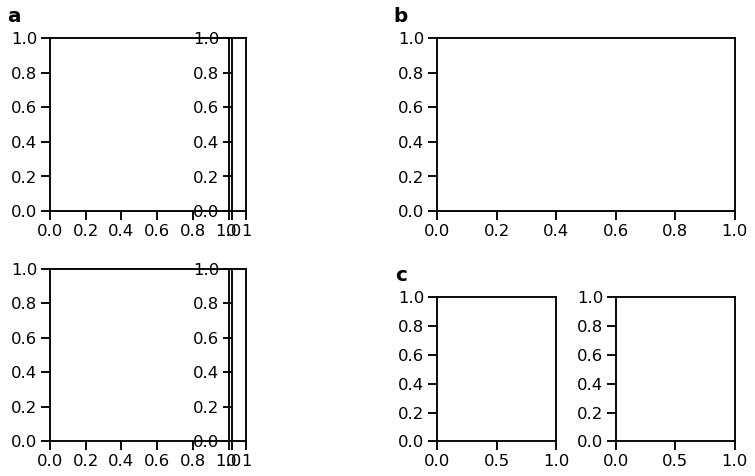

In [9]:
with sns.plotting_context(**plotting_context):

    fig = plt.figure(figsize=(dina4_width_inch, 8))

    # debugging
    # left, bottom, width, height
    # fake = fig.add_axes([0, 0, 1, 1])
    # fig.set_facecolor("lightgray")

    ax3a_upper = fig.add_axes([0.00, 0.4, 0.3, 0.3])
    ax3a_lower = fig.add_axes(
        [0.00, 0.0, 0.3, 0.3], sharey=ax3a_upper, sharex=ax3a_upper
    )

    ax3b = fig.add_axes([0.65, 0.40, 0.50, 0.30])

    ax3c_left = fig.add_axes([0.65, 0.00, 0.20, 0.25])
    ax3c_right = fig.add_axes(
        [0.95, 0.00, 0.20, 0.25], sharey=ax3c_left, sharex=ax3c_left
    )

    # cbar axes
    cax3a_upper = fig.add_axes([0.3 + 0.005, 0.4, 0.025, 0.3])
    cax3a_lower = fig.add_axes([0.3 + 0.005, 0.0, 0.025, 0.3])

    # need to collect some objs to later form a tight box around the plot
    extra_artists = []

    # plot panel letters
    # see: https://gitter.im/matplotlib/matplotlib?at=5fb53257c6fe0131d40227bb
    axs = np.array([ax3a_upper, ax3a_lower, ax3b, ax3c_left, ax3c_right])
    for ax, label in zip(axs.flat, (i for i in ["a", "", "b", "c", ""])):

        x = -0.5
        y = 0.3
        offset = transforms.ScaledTranslation(x, y, fig.dpi_scale_trans)
        transform = ax.transAxes + offset

        ax.text(
            s=label,
            x=0,
            y=1,
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=plt.rcParams["font.size"] + 2,
            transform=transform,
        )

        if label in ["a", "b", "c"]:
            extra_artists.append(ax)

## calculations

In [10]:
# Where the RSA results are stored
results_folder = "cv-False_flip-False_rsa-pearson_dist-euclidean_half-both_"
results_folder += "exclude-Identity_mnn-FalseFalseFalse_ec-False_"
results_folder += "c-(0.6, 1.6)t--0.8s-150b-(None, 0)s-True_outcome"

rsa_results_path = os.path.join(
    BIDS_ROOT,
    "derivatives",
    "rsa_9x9",
    results_folder,
)

results = os.path.join(rsa_results_path, "rsa_results.csv")
results_first_half = results.replace("half-both", "half-first")
results_second_half = results.replace("half-both", "half-second")

In [11]:
just_plot = False

In [12]:
effect = "orthnumberline_length"  # orthnumberline_length, orthextremity_length
stat_effect_to_plot = "interaction"  # sampling, stopping, interaction

add_extremity_to_fig3 = True

In [13]:
if add_extremity_to_fig3:
    # add axes for extremity
    with sns.plotting_context(**plotting_context):
        # left bottom width height
        ax3d = fig.add_axes([0.0, -0.5, 0.3, 0.3])
        cax3d = fig.add_axes([0.3 + 0.005, -0.5, 0.025, 0.3])

        ax3e = fig.add_axes([0.65, -0.5, 0.50, 0.30])

        # plot panel letters
        # see: https://gitter.im/matplotlib/matplotlib?at=5fb53257c6fe0131d40227bb
        axs = np.array([ax3d, ax3e])
        for ax, label in zip(axs.flat, (i for i in "de")):

            x = -0.5
            y = 0.3
            offset = transforms.ScaledTranslation(x, y, fig.dpi_scale_trans)
            transform = ax.transAxes + offset

            ax.text(
                s=label,
                x=0,
                y=1,
                ha="center",
                va="center",
                fontweight="bold",
                fontsize=plt.rcParams["font.size"] + 2,
                transform=transform,
            )

            extra_artists.append(ax)

In [14]:
def _calculations(effect, stat_effect_to_plot, rsa_results_path):

    # get names from effect
    _modelname, clusterstat = effect.split("_")
    orth = True if _modelname.startswith("orth") else False
    modelname = _modelname.lstrip("orth")

    print(
        f"Working on {effect}, (orth:{orth}, modelname:{modelname})\nStat:{stat_effect_to_plot}"
    )

    effect_mod = "o" + modelname if orth else modelname

    average_effect_json = os.path.join(
        rsa_results_path,
        "perm_and_2x2_outputs",
        effect,
        f"average_{effect_mod}_clusters.json",
    )
    with open(average_effect_json, "r") as fin:
        average_effect_clusters = json.load(fin)

    print(f"{len(average_effect_clusters)} average effect clusters found.")

    # Load permutation distribution, if multiple available, take first
    clusterperm_results_dirs = glob.glob(
        os.path.join(rsa_results_path, "clusterperm_results_*")
    )
    if len(clusterperm_results_dirs) == 0:
        raise RuntimeError(
            f"Could not find a clusterperm dir on:\n\n{rsa_results_path}"
        )

    clusterperm_results_dir = sorted(clusterperm_results_dirs)[0]
    if len(clusterperm_results_dirs) > 1:
        warnings.warn(
            f"Found multiple clusterperm dirs on:\n\n{rsa_results_path}\n\n"
            f"taking the first:\n\n{clusterperm_results_dir}"
        )
    cluster_distr_file = os.path.join(
        clusterperm_results_dir,
        f"model-{modelname}_stat-length_thresh-0.05_distr.npy",
    )

    # Get column order
    cluster_distr_col_order_file = cluster_distr_file.replace(
        ".npy", "_column_order.txt"
    )
    with open(cluster_distr_col_order_file, "r") as fin:
        lines = fin.readlines()
    column_order = [line.strip() for line in lines]
    effect_order = ["stopping", "sampling", "Interaction"]
    assert column_order == [i.lower() for i in effect_order]

    # Load data
    df_rsa = pd.read_csv(results)
    df_rsa_first_half = pd.read_csv(results_first_half)
    df_rsa_second_half = pd.read_csv(results_second_half)

    # find the rsa_method that was used
    assert (
        df_rsa["method"].nunique() == 1
    ), f"more than one rsa_method detected: {df_rsa['method']}"
    rsa_method = df_rsa["method"].unique()[0]

    # find the distance metric that was used
    assert (
        df_rsa["distance_metric"].nunique() == 1
    ), f"more than one distance_metric detected: {df_rsa['distance_metric']}"
    distance_metric = df_rsa["distance_metric"].unique()[0]

    print(
        f"Using rsa_method: >> {rsa_method}\nwith distance_metric: >> {distance_metric}"
    )

    thresh = 0.05
    clusterthresh = 0.05

    # model
    model = "o_" + modelname if orth else modelname
    df_rsa_model_orth = df_rsa[
        (df_rsa["orth"] == orth) & (df_rsa["model"] == modelname)
    ]

    assert df_rsa_model_orth["model"].nunique() == 1

    # find the observed clusters in the data
    clusters_obs, models_obs = return_observed_clusters(
        df_rsa_model_orth, thresh, pingouin.mixed_anova
    )

    # Load cluster distribution array
    cluster_distr = np.load(cluster_distr_file)

    # turn into data frame
    cluster_distr = pd.DataFrame(cluster_distr, columns=column_order)

    # evaluate the significance of the observed clusters
    (clustersig_threshs, clusters_obs_stats, clusters_obs_sig,) = evaluate_significance(
        cluster_distr, clusters_obs, clusterstat, clusterthresh, models_obs
    )

    times = df_rsa["time_s"].unique()
    sig_clu_to_plot = False

    # Find start and stop of largest effect
    _ = [len(i) for i in clusters_obs_sig[stat_effect_to_plot]]
    if len(_) > 0:
        cluster_effect_to_plot = clusters_obs_sig[stat_effect_to_plot][np.argmax(_)]
        cluster_effect_to_plot_times = times[cluster_effect_to_plot]
        tstart, tstop = (
            cluster_effect_to_plot_times[0],
            cluster_effect_to_plot_times[-1],
        )
        _extent = np.round(tstart, 2), np.round(tstop, 2)
        print(f"Cluster extent in seconds: {_extent}")
        sig_clu_to_plot = True

    else:
        cluster_effect_to_plot = []
        cluster_effect_to_plot_times = np.array([])
        print("No significant cluster")

    # Find start and stop of AVERAGE effect
    # picking the largest of all average clusters
    which_ave_cluster = "{}".format(
        np.argmax([len(val["cluster"]) for key, val in average_effect_clusters.items()])
    )
    print(
        "p =",
        np.format_float_positional(average_effect_clusters[which_ave_cluster]["p-val"]),
    )
    tmp = times[average_effect_clusters[which_ave_cluster]["cluster"]]
    tstart, tstop = tmp[0], tmp[-1]
    _extent = np.round(tstart, 2), np.round(tstop, 2)
    print(f"Cluster extent in seconds: {_extent}")

    return (
        df_rsa_model_orth,
        df_rsa_first_half,
        df_rsa_second_half,
        model,
        modelname,
        orth,
        clusters_obs_sig,
        cluster_effect_to_plot,
        average_effect_clusters,
        rsa_method,
        times,
        sig_clu_to_plot,
        which_ave_cluster,
    )

In [15]:
(
    df_rsa_model_orth,
    df_rsa_first_half,
    df_rsa_second_half,
    model,
    modelname,
    orth,
    clusters_obs_sig,
    cluster_effect_to_plot,
    average_effect_clusters,
    rsa_method,
    times,
    sig_clu_to_plot,
    which_ave_cluster,
) = _calculations(effect, stat_effect_to_plot, rsa_results_path)

Working on orthnumberline_length, (orth:True, modelname:numberline)
Stat:interaction
3 average effect clusters found.
Using rsa_method: >> pearson
with distance_metric: >> euclidean
Cluster extent in seconds: (0.32, 0.58)
p = 0.00009999000099990002
Cluster extent in seconds: (0.16, 0.8)


## panel 3a upper

In [16]:
def prep_to_plot(rdm):
    """Remove upper triangle from rdm."""
    tri_idx = np.triu_indices(rdm.shape[0])
    tmprdm = rdm.copy()
    tmprdm = tmprdm.astype(float)
    tmprdm[tri_idx] = np.nan
    return tmprdm

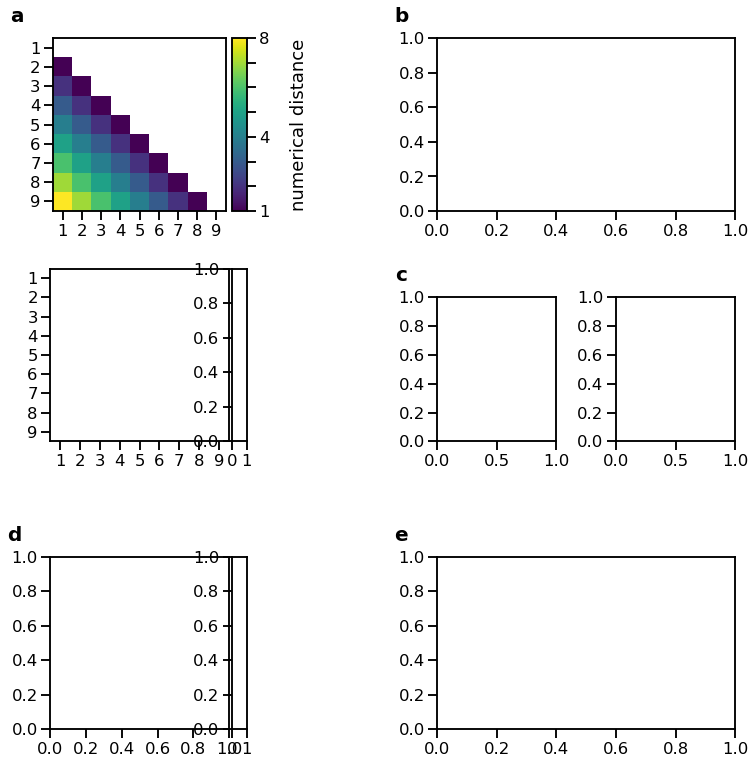

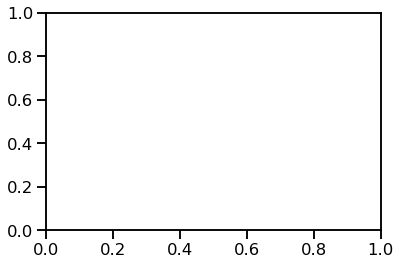

In [17]:
with sns.plotting_context(**plotting_context):

    name = model.lstrip("o_")
    rdm = get_model_rdm(name, normalize=False)
    thismax = int(rdm.max())
    to_plot = prep_to_plot(rdm)

    im = ax3a_upper.imshow(to_plot, cmap="viridis")

    cbar = plt.colorbar(im, cax=cax3a_upper)

    # ticklabels and labels
    cbar.set_ticks(range(0, thismax + 2))
    _labelmod = (1, 4, 8) if name == "numberline" else (0, 2, 4)
    cbar.ax.set_yticklabels(
        [i if i in _labelmod else "" for i in range(0, thismax + 2)]
    )

    _label = "numerical distance" if name == "numberline" else "extremity distance"

    _t1 = cax3a_upper.text(
        x=4.5,
        y=0.5,
        s=_label,
        ha="center",
        va="center",
        rotation="vertical",
        color="black",
        transform=cax3a_upper.transAxes,
    )

    ax3a_upper.set_xticks(range(9))
    ax3a_upper.set_yticks(range(9))

    use_all_number_labels = True
    if use_all_number_labels:
        ax3a_ticklabels = range(1, 10)
    else:
        [i if i % 2 != 0 else "" for i in range(1, 10)]
    ax3a_upper.set_xticklabels(ax3a_ticklabels)
    ax3a_upper.set_yticklabels(ax3a_ticklabels)

fig

## panel 3b

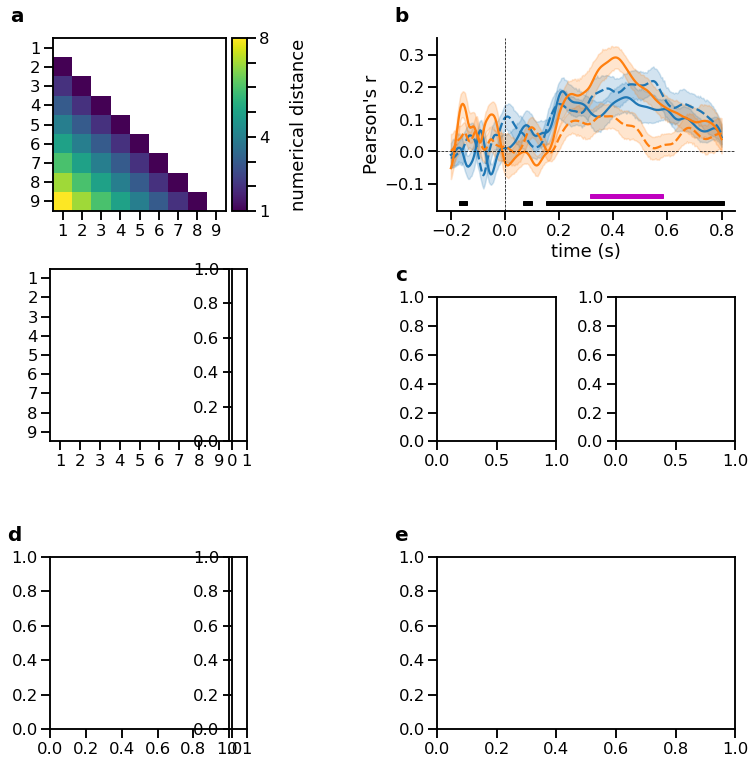

In [18]:
with sns.plotting_context(**plotting_context):

    hue = "stopping"
    hue_order = stopping_order
    style = "sampling"
    style_order = sampling_order

    # Plot this group
    sns.lineplot(
        x="time_s",
        y="similarity",
        ci=68,
        hue=hue,
        hue_order=hue_order,
        style=style,
        style_order=style_order,
        legend=False,
        data=df_rsa_model_orth,
        ax=ax3b,
    )

    # Plot interaction effect
    try:
        stat_effect_significant = np.concatenate(clusters_obs_sig[stat_effect_to_plot])
        if len(clusters_obs_sig[stat_effect_to_plot]) > 1:
            print("WARNING: concatenating several clusters")
        else:
            np.testing.assert_array_equal(
                cluster_effect_to_plot, stat_effect_significant
            )

    except ValueError:
        stat_effect_significant = []

    xs = df_rsa_model_orth["time_s"].unique()
    xs = xs[stat_effect_significant]
    ys = np.repeat(ax3b.get_ylim()[0], xs.shape[-1])
    color = "m"
    with sns.plotting_context("paper"):
        (line,) = ax3b.plot(xs, ys, marker="s", color=color, linestyle="None")

    lab = stat_effect_to_plot
    line.set_label(lab)

    # plot general effect
    # Get all cluster indices
    _clusters = [d["cluster"] for i, d in average_effect_clusters.items()]

    # plot general numberline effect into panel
    xs = df_rsa_model_orth["time_s"].unique()
    xs = xs[np.concatenate(_clusters)]
    ys = np.repeat(ax3b.get_ylim()[0], xs.shape[-1])
    color = "k"
    with sns.plotting_context("paper"):
        (line,) = ax3b.plot(xs, ys, marker="s", color=color, linestyle="None")
    line.set_label(f"mean {modelname}")

    # Plot Zero lines
    ax3b.axhline(0, linestyle="--", color="black", linewidth=0.75)
    ax3b.axvline(0, linestyle="--", color="black", linewidth=0.75)

    ax3b.set_xlabel("time (s)")
    ax3b.set_ylabel(f"{rsa_method.capitalize()}'s r")

    sns.despine(ax=ax3b)
fig

### legend

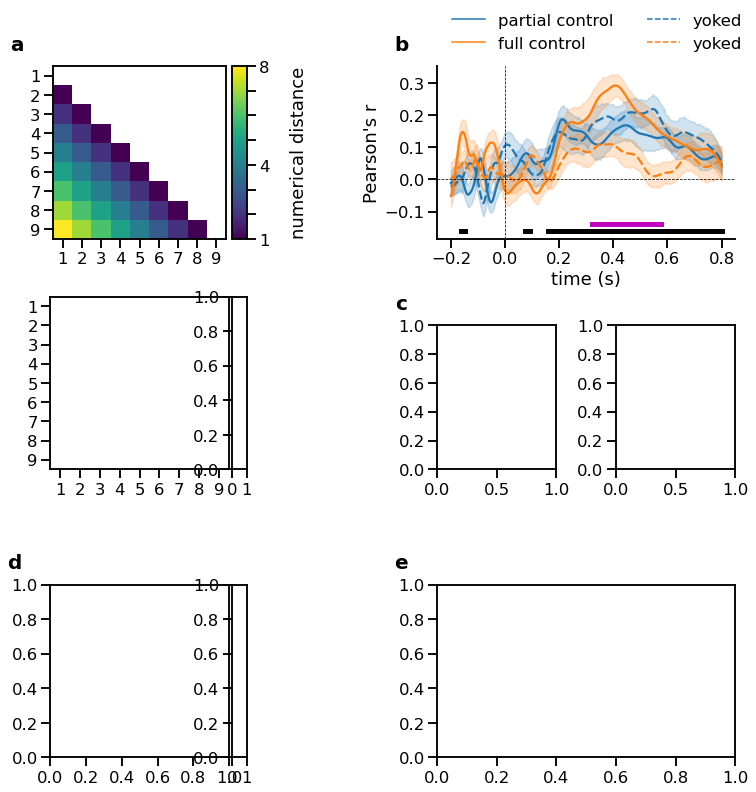

In [19]:
# get the correct orderings in plotting
# NOTE: pd.unique provides in the order "as found"
stopping_order = list(pd.unique(df_rsa_model_orth["stopping"]))
sampling_order = list(pd.unique(df_rsa_model_orth["sampling"]))

# The following legend is encoded according to these assumptions:
assert stopping_order == hue_order
assert sampling_order == style_order

# add legend
# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = []
for linestyle in ["-", "--"]:
    for i, label in enumerate(["partial control", "full control"]):

        if linestyle == "--":
            label = "yoked"

        color = sns.color_palette()[i]
        legend_elements.append(
            Line2D(
                [0], [0], color=color, marker=None, label=label, linestyle=linestyle
            ),
        )

with sns.plotting_context(**plotting_context):
    legend3b = fig.legend(
        handles=legend_elements,
        loc="lower left",
        bbox_to_anchor=(ax3b.get_xlim()[0], ax3b.get_ylim()[1]),
        bbox_transform=ax3b.axes.transData,
        framealpha=1,
        frameon=False,
        ncol=2,
        title="",  # "Sampling"
    )

    extra_artists.append(legend3b)

fig

## panel 3a lower

In [20]:
# Determine based on what time window to plot the cluster

eeg_rdm_window = "custom"  # largest_cluster, average_cluster, custom

if eeg_rdm_window == "largest_cluster":
    # Take the stat_effect_to_plot cluster
    max_cluster = cluster_effect_to_plot.copy()
elif eeg_rdm_window == "average_cluster":
    # Get *average* cluster indices of the one we also plotted in panel b
    max_cluster = average_effect_clusters[which_ave_cluster]["cluster"]
elif eeg_rdm_window == "custom":
    custom_window = (0.3, 0.6)
    max_cluster = find_time_idxs(custom_window, times)
    max_cluster
else:
    raise ValueError("unknown eeg_rdm_window")

In [21]:
subjects = range(1, 41)
tasks = ("AF", "AV", "YF", "YV")

rdms_folder_template = os.path.join(
    rsa_results_path, "single_subj_plots", "sub-{:02}_task-{}_rdm_times.npy"
)

In [22]:
if not just_plot:

    # Go over subjects and tasks
    # save RDMs in a large array for later averaging
    # all_rdms is (40 x 4 x 9 x 9) containing the RDMs averaged over the
    # max_cluster window ... half of the arrays are NaN, because each
    # of the 40 subjs only had 2, instead of 4 tasks

    all_rdms = np.full((len(subjects), len(tasks), 9, 9), np.nan)
    did_not_find = 0
    for isubj, subj in enumerate(subjects):

        for itask, task in enumerate(tasks):

            fname = rdms_folder_template.format(subj, task)
            if not os.path.exists(fname):
                did_not_find += 1
                continue

            rdm_times = np.load(fname)
            rdm_average = np.mean(rdm_times[..., max_cluster], axis=-1)
            all_rdms[isubj, itask, ...] = rdm_average

    # Make RDM over all subjects and tasks
    # 1x1 plot (1 panel)
    subj_mean = np.nanmean(all_rdms, axis=0)
    subj_task_mean = np.nanmean(subj_mean, axis=0)

In [23]:
if did_not_find == len(subjects) * 2:
    pass  # everything as expected, 2 of 4 tasks for each subj should be skipped
else:
    raise ValueError(f"unexpected number of rdm_times.npy found: {did_not_find}")

In [24]:
look_only_at_full_control_for_panel_a_lower = False

if look_only_at_full_control_for_panel_a_lower:
    # look only at FULL CONTROL for panel C
    print("Plotting panel C only with full control data!")
    full_control_idx = list(tasks).index("AV")
    subj_mean = np.nanmean(all_rdms[:, full_control_idx:, ...], axis=0)
    subj_task_mean = np.nanmean(subj_mean, axis=0)

In [25]:
_do_normalization = False

if _do_normalization:
    # normalize distances to range 0 - 1
    subj_task_mean = (subj_task_mean - np.nanmin(subj_task_mean)) / (
        np.nanmax(subj_task_mean) - np.nanmin(subj_task_mean)
    )

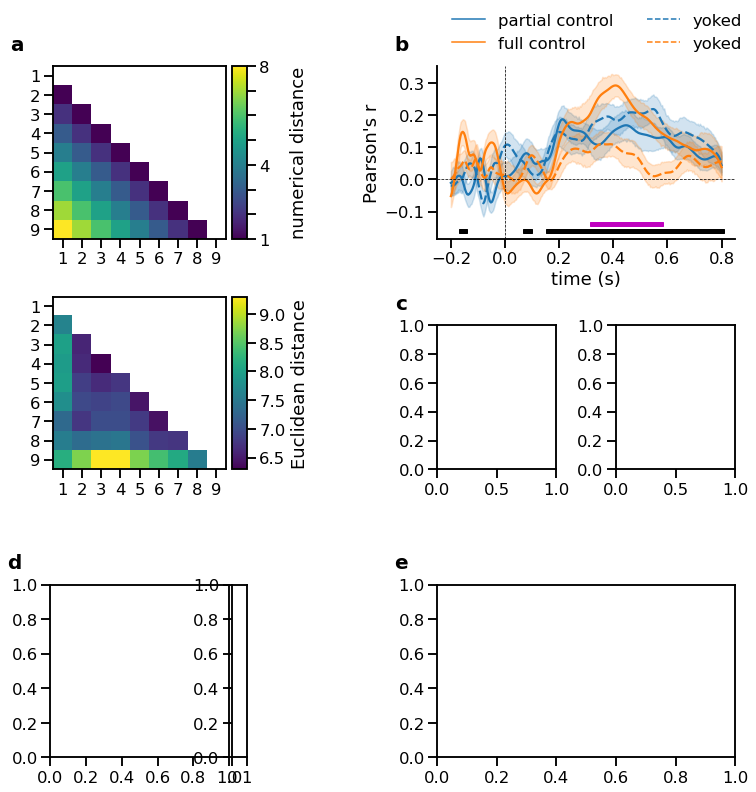

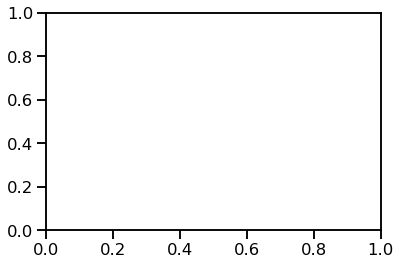

In [26]:
with sns.plotting_context(**plotting_context):

    to_plot = prep_to_plot(subj_task_mean)

    im = ax3a_lower.imshow(to_plot, cmap="viridis")

    cbar = plt.colorbar(im, cax=cax3a_lower)

    # ticklabels and labels

    _t2 = cax3a_lower.text(
        x=4.55,
        y=0.5,
        s="Euclidean distance",
        ha="center",
        va="center",
        rotation="vertical",
        color="black",
        transform=cax3a_lower.transAxes,
    )

fig

## panel 3c left+right

In [27]:
data = {
    "first_half": df_rsa_first_half,
    "second_half": df_rsa_second_half,
}

In [28]:
if sig_clu_to_plot:
    # go over largest sig. cluster window
    largest_idx = np.argmax([len(i) for i in clusters_obs_sig[stat_effect_to_plot]])
    stat_effect_significant_largest = clusters_obs_sig[stat_effect_to_plot][largest_idx]
    assert cluster_effect_to_plot == stat_effect_significant_largest
else:
    assert sig_clu_to_plot == False
    # if no sig. cluster, go over largest average window
    stat_effect_significant_largest = average_effect_clusters[which_ave_cluster][
        "cluster"
    ]

In [29]:
dfs = {}
for half, tmp in data.items():
    grp = tmp[(tmp["orth"] == orth) & (tmp["model"] == modelname)]

    # take mean across significant cluster window
    time_idxs = grp["itime"].unique()[stat_effect_significant_largest]

    tmp = grp[grp["itime"].isin(time_idxs)]
    tmp = (
        tmp.groupby(["subject", "stopping", "sampling", "orth", "model"])
        .mean()
        .reset_index()
    )
    tmp = tmp[["subject", "stopping", "sampling", "orth", "model", "similarity"]]

    # tmp "save"
    dfs[half] = tmp

In [30]:
with sns.plotting_context(**plotting_context):

    x = "sampling"
    order = sampling_order
    y = "similarity"
    hue = "stopping"
    hue_order = stopping_order

    # 3d
    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        # plot
        sns.pointplot(
            x=x,
            order=order,
            y=y,
            hue=hue,
            hue_order=hue_order,
            data=dfs["first_half"],
            ci=68,
            dodge=pointdodge,
            ax=ax3c_left,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    # --------------------------- plot single subj dots

    sns.swarmplot(
        x=x,
        order=order,
        y=y,
        hue=hue,
        hue_order=hue_order,
        data=dfs["first_half"],
        ax=ax3c_left,
        dodge=True,
        size=swarmsize,
    )

    # connect subj dots
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax3c_left.get_children()[idx0].get_offsets()
        locs2 = ax3c_left.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            _x = [locs1[i, 0], locs2[i, 0]]
            _y = [locs1[i, 1], locs2[i, 1]]
            ax3c_left.plot(_x, _y, **subj_line_settings)

    # ---------------------------

    ax3c_left.get_legend().remove()
    sns.despine(ax=ax3c_left)

    # Plot Zero lines
    ax3c_left.axhline(0, linestyle="--", color="black", linewidth=0.75)

    ax3c_left.set_xlabel("")
    ax3c_left.set_xticklabels(["self-\ncontrolled", "yoked"], rotation=45)
    ax3c_left.set_ylabel("Pearson's r")

    ax3c_left.set_title("early samples")

    # 3e
    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        # plot
        sns.pointplot(
            x="sampling",
            order=order,
            y="similarity",
            hue=hue,
            hue_order=hue_order,
            data=dfs["second_half"],
            ci=68,
            dodge=pointdodge,
            ax=ax3c_right,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    # --------------------------- plot single subj dots

    sns.swarmplot(
        x=x,
        order=order,
        y=y,
        hue=hue,
        hue_order=hue_order,
        data=dfs["second_half"],
        ax=ax3c_right,
        dodge=True,
        size=swarmsize,
    )

    # connect subj dots
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax3c_right.get_children()[idx0].get_offsets()
        locs2 = ax3c_right.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            _x = [locs1[i, 0], locs2[i, 0]]
            _y = [locs1[i, 1], locs2[i, 1]]
            ax3c_right.plot(_x, _y, **subj_line_settings)

    # ---------------------------
    ax3c_right.get_legend().remove()
    sns.despine(ax=ax3c_right)

    # Plot Zero lines
    ax3c_right.axhline(0, linestyle="--", color="black", linewidth=0.75)

    ax3c_right.set_xlabel("")
    ax3c_right.set_xticklabels(["self-\ncontrolled", "yoked"], rotation=45)

    ax3c_right.set_title("late samples")

    # Make ylims consistent
    ymin = min(min(ax3c_left.get_ylim()), min(ax3c_right.get_ylim())) * 1.5
    ymax = max(max(ax3c_left.get_ylim()), max(ax3c_right.get_ylim()))

    ax3c_left.set_ylim((ymin, ymax))
    ax3c_right.set_ylim((ymin, ymax))
    ax3c_right.set_ylabel("")

    # ... but tweak ylim so that we have a negative y value
    ylim = list(ax3c_left.get_ylim())
    ylim[0] = -0.1
    ax3c_left.set_ylim(ylim)

In [31]:
just_plot = True

## tweaks

In [33]:
# Store the axis limits of some panels here.
# In case we set add_extremity_to_fig3=False and name = "extremity",
# this will allow us to produce a figure of only 2 panels on extremity results
# where the limits are identical to the figure where name = "numberline"
ax3b_ylim = (-0.18501336333224894, 0.35309577438088613)
ax3c_left_ylim = (-0.1, 0.7151948522554632)


if add_extremity_to_fig3:
    # If we make a combined numberline + extremity figure, the code here is
    # irrelevant: We can pass
    pass
elif (not add_extremity_to_fig3) and name == "numberline":
    # assert the axis limits are the same as when "stored" (see above)
    # else, we need to adjust
    _b = ax3b.get_ylim()
    _c = ax3c_left.get_ylim()
    assert _b == ax3b_ylim, f"\nPanel B\nwant:{_b}\ngot:{ax3b_ylim}"
    assert _c == ax3c_left_ylim, f"\nPanel C\nwant:{_c}\ngot:{ax3c_left_ylim}"
else:
    assert (not add_extremity_to_fig3) and name == "extremity"
    ax3b.set_ylim(ax3b_ylim)
    ax3c_left.set_ylim(ax3c_left_ylim)

    # need to fix legend for panel b afterwards
    legend3b.set_bbox_to_anchor(
        (ax3b.get_xlim()[0], ax3b.get_ylim()[1]), transform=ax3b.transData
    )

In [34]:
# to make the xticks "narrower" / squeeze them horizontally
# at the expense of having whitespace
normal = (-0.5, 1.5)
narrow = (-0.75, 1.75)
ax3c_left.set_xlim(normal)
ax3c_right.set_xlim(normal)

(-0.5, 1.5)

In [35]:
# optionally keep only a part of the figure
only_a_upper_and_b = True if name == "extremity" else False

if name == "extremity" and only_a_upper_and_b:
    ax3a_lower.remove()
    cax3a_lower.remove()
    ax3c_left.remove()
    ax3c_right.remove()
    extra_artists = extra_artists[0:2]

Working on orthextremity_length, (orth:True, modelname:extremity)
Stat:sampling
2 average effect clusters found.
Using rsa_method: >> pearson
with distance_metric: >> euclidean
No significant cluster
p = 0.00009999000099990002
Cluster extent in seconds: (0.26, 0.8)


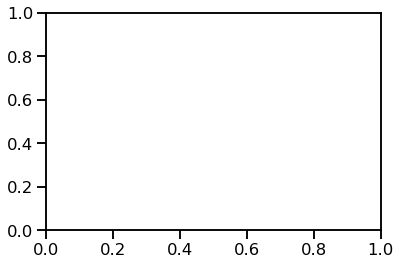

In [36]:
if add_extremity_to_fig3:

    # get data for extremity, pick only what we need, rest assigned to _
    (
        df_rsa_model_orth,
        _,
        _,
        model,
        modelname,
        orth,
        clusters_obs_sig,
        cluster_effect_to_plot,
        average_effect_clusters,
        rsa_method,
        _,
        _,
        _,
    ) = _calculations(
        effect="orthextremity_length",
        stat_effect_to_plot="sampling",
        rsa_results_path=rsa_results_path,
    )

    # need to recompute if re-run script
    just_plot = False

    with sns.plotting_context(**plotting_context):

        # add panel d
        # -----------
        rdm = get_model_rdm("extremity", normalize=False)
        thismax = int(rdm.max())
        to_plot = prep_to_plot(rdm)

        im = ax3d.imshow(to_plot, cmap="viridis")

        cbar = plt.colorbar(im, cax=cax3d)

        # ticklabels and labels
        cbar.set_ticks(range(0, thismax + 2))
        cbar.ax.set_yticklabels(
            [i if i in (0, 2, 4) else "" for i in range(0, thismax + 2)]
        )

        _label = "extremity distance"

        _t1 = cax3d.text(
            x=4.5,
            y=0.5,
            s=_label,
            ha="center",
            va="center",
            rotation="vertical",
            color="black",
            transform=cax3d.transAxes,
        )

        ax3d.set_xticks(range(9))
        ax3d.set_yticks(range(9))

        use_all_number_labels = True
        if use_all_number_labels:
            ax3d_ticklabels = range(1, 10)
        else:
            [i if i % 2 != 0 else "" for i in range(1, 10)]
        ax3d.set_xticklabels(ax3d_ticklabels)
        ax3d.set_yticklabels(ax3d_ticklabels)

        # add panel e
        # -----------
        hue = "stopping"
        hue_order = stopping_order
        style = "sampling"
        style_order = sampling_order

        # Plot this group
        sns.lineplot(
            x="time_s",
            y="similarity",
            ci=68,
            hue=hue,
            hue_order=hue_order,
            style=style,
            style_order=style_order,
            legend=False,
            data=df_rsa_model_orth,
            ax=ax3e,
        )

        # Plot interaction effect
        try:
            stat_effect_significant = np.concatenate(
                clusters_obs_sig[stat_effect_to_plot]
            )
            if len(clusters_obs_sig[stat_effect_to_plot]) > 1:
                print("WARNING: concatenating several clusters")
            else:
                np.testing.assert_array_equal(
                    cluster_effect_to_plot, stat_effect_significant
                )

        except ValueError:
            stat_effect_significant = []

        xs = df_rsa_model_orth["time_s"].unique()
        xs = xs[stat_effect_significant]
        ys = np.repeat(ax3e.get_ylim()[0], xs.shape[-1])
        color = "m"
        with sns.plotting_context("paper"):
            (line,) = ax3e.plot(xs, ys, marker="s", color=color, linestyle="None")

        lab = stat_effect_to_plot
        line.set_label(lab)

        # plot general effect
        # Get all cluster indices
        _clusters = [d["cluster"] for i, d in average_effect_clusters.items()]

        # plot general numberline effect into panel
        xs = df_rsa_model_orth["time_s"].unique()
        xs = xs[np.concatenate(_clusters)]
        ys = np.repeat(ax3e.get_ylim()[0], xs.shape[-1])
        color = "k"
        with sns.plotting_context("paper"):
            (line,) = ax3e.plot(xs, ys, marker="s", color=color, linestyle="None")
        line.set_label(f"mean {modelname}")

        # Plot Zero lines
        ax3e.axhline(0, linestyle="--", color="black", linewidth=0.75)
        ax3e.axvline(0, linestyle="--", color="black", linewidth=0.75)

        ax3e.set_xlabel("time (s)")
        ax3e.set_ylabel(f"{rsa_method.capitalize()}'s r")

        sns.despine(ax=ax3e)

        # adjust ylim to be same as for numberline
        ax3e.set_ylim(ax3b_ylim)

## finish

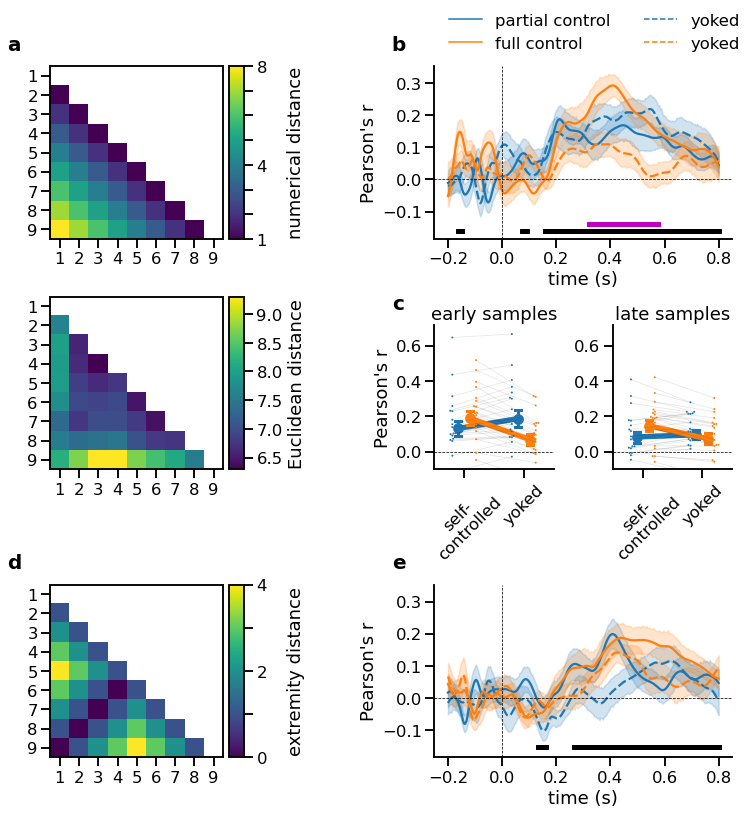

In [37]:
fname = f"fig3_{effect}" if not add_extremity_to_fig3 else "fig3_combined"
fname = os.path.join(plotdir, fname)

for ext in [".pdf", ".png"]:
    fname_save = fname + ext
    dpi = 300 if ext == ".png" else None
    fig.savefig(
        fname_save, bbox_extra_artists=extra_artists, bbox_inches="tight", dpi=dpi
    )

fig

# Neurometrics figure

## settings

In [494]:
tasks = ("AF", "AV", "YF", "YV")
model_to_use = "both"
biasmax = 0.75
kappamax = 10.0
corr_method = "pearson"

## start

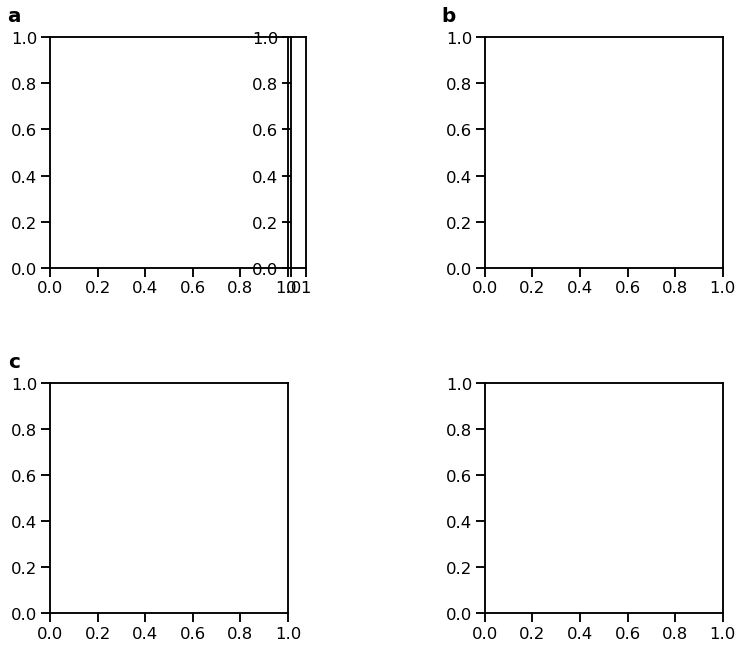

In [495]:
with sns.plotting_context(**plotting_context):

    fig = plt.figure(figsize=(dina4_width_inch, 8))

    width = 0.4
    height = 0.4

    horz_space = 0.3
    vert_space = 0.1

    ax1_rect = [0.0, 0.5 + vert_space, width, height]
    ax1 = fig.add_axes(ax1_rect)

    # cbar axes
    cbar_width = 0.025
    cbar_space = 0.005
    cax1_rect = [
        ax1_rect[0] + ax1_rect[2] + cbar_space,
        ax1_rect[1],
        cbar_width,
        ax1_rect[-1],
    ]
    cax1 = fig.add_axes(cax1_rect)

    ax2_rect = [
        cbar_width + cbar_space + width + horz_space,
        0.5 + vert_space,
        width,
        height,
    ]
    ax2 = fig.add_axes(ax2_rect)

    ax3_rect = [0.0, 0.0, width, height]
    ax3 = fig.add_axes(ax3_rect)

    ax4_rect = [cbar_width + cbar_space + width + horz_space, 0.0, width, height]
    ax4 = fig.add_axes(ax4_rect)

    # need to collect some objs to later form a tight box around the plot
    extra_artists = []

    # plot panel letters
    # see: https://gitter.im/matplotlib/matplotlib?at=5fb53257c6fe0131d40227bb
    axs = np.array([ax1, ax2, ax3, ax4])
    for ax, label in zip(axs.flat, (i for i in ["a", "b", "c", ""])):

        x = -0.5
        y = 0.3
        offset = transforms.ScaledTranslation(x, y, fig.dpi_scale_trans)
        transform = ax.transAxes + offset

        ax.text(
            s=label,
            x=0,
            y=1,
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=plt.rcParams["font.size"] + 2,
            transform=transform,
        )

        if label in ["a", "b", "c", "d"]:
            extra_artists.append(ax)

## Panel 1

In [496]:
tasks_to_use = "all"  # "all" or tasks
plotdir = os.path.join(BIDS_ROOT, "code", "publication_plots")
fname_all = os.path.join(
    plotdir,
    f"nm_data_{'-'.join(tasks_to_use)}_{corr_method}_b-{biasmax}_k-{kappamax}.pickle",
)
with open(fname_all, "rb") as fin:
    loaddict = pickle.load(fin)

bias_kappa_combis, biases, kappas, bias_0_idx, kappa_1_idx = loaddict["bias_kappa_info"]
neurometrics_data_all = dict(loaddict)
del neurometrics_data_all["bias_kappa_info"]

In [497]:
(
    coef_map,
    pval_map_subjs,
    tval_map,
    pval_map,
    subj_maxima,
    wilcoxon,
) = neurometrics_data_all[model_to_use]

In [498]:
_coefmap_to_plot = np.mean(coef_map, axis=0)
_tmap_to_plot = tval_map[...]
_pmap_to_plot = pval_map[...]

In [499]:
# Make a "mask" for significant pixels
# mask = np.ones_like(_pmap_to_plot)
# mask[(_pmap_to_plot < 0.05) & (_coefmap_to_plot >= 0)] = 0.75
# mask[(_pmap_to_plot > 0.05) | (_coefmap_to_plot < 0)] = 0.75

# use B/H FDR correction
sig, pval_corr = statsmodels.stats.multitest.fdrcorrection(
    _pmap_to_plot.flatten(), alpha=0.001
)
sig = sig.reshape(_pmap_to_plot.shape)

mask = sig.copy().astype(float)
mask[mask == 0] = 0.75
mask[_coefmap_to_plot <= 0] = 0.75

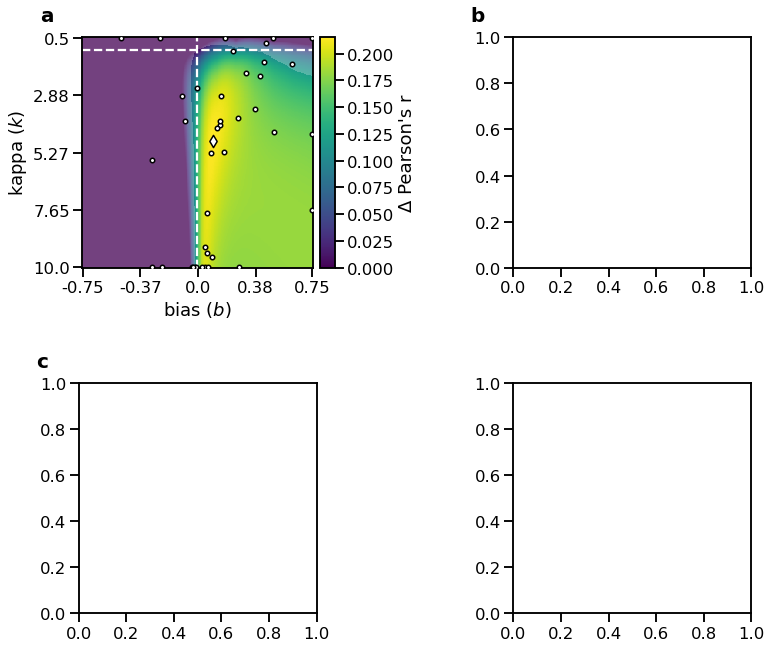

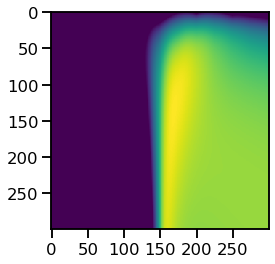

In [500]:
plot_mapmean_instead_of_subjmean_panel_4a = True


with sns.plotting_context(**plotting_context):

    # plot the image
    _ = ax1.imshow(
        _coefmap_to_plot, origin="upper", interpolation="nearest", vmin=0, alpha=mask
    )

    # need to plot an additional tweak image with same settings BUT without alpha
    # so that the colorbar renders correctly
    _, _tweak_ax = plt.subplots()
    im1 = _tweak_ax.imshow(
        _coefmap_to_plot, origin="upper", interpolation="nearest", vmin=0
    )

    # add colorbar
    _lab = {"pearson": "Δ Pearson's r", "kendall_a": "Δ Kendall's tau"}[corr_method]
    cbar = plt.colorbar(im1, cax=cax1, label=_lab)

    # plot "cross" at bias 0 and kappa 1
    ax1.axvline(bias_0_idx, color="white", linestyle="--", zorder=1)
    ax1.axhline(kappa_1_idx, color="white", linestyle="--", zorder=1)

    # plot single subjects
    # subj_maxima are (ycoord, xcoord, value)
    ax1.scatter(
        subj_maxima[..., 0:2][:, 1],
        subj_maxima[..., 0:2][:, 0],
        marker="o",
        facecolor="white",
        edgecolor="black",
        s=20,
        zorder=5,
    )

    # plot single summary point
    if plot_mapmean_instead_of_subjmean_panel_4a:
        kappa_idx_mean, bias_idx_mean = np.unravel_index(
            np.argmax(_coefmap_to_plot), _coefmap_to_plot.shape
        )
    else:
        kappa_idx_mean, bias_idx_mean = np.around(
            np.mean(subj_maxima[..., 0:2], axis=0)
        ).astype(int)

    ax1.scatter(
        bias_idx_mean,
        kappa_idx_mean,
        marker="d",
        facecolor="white",
        edgecolor="black",
        s=75,
        zorder=10,
    )

    # settings
    n = _coefmap_to_plot.shape[0]
    step = int(n / 4)
    ticks = np.arange(0, n, step)
    ticks = np.append(ticks, n - 1)

    _ = ax1.set(
        xticks=ticks,
        xticklabels=biases[ticks].round(2),
        xlabel="bias ($\it{b}$)",
        yticks=ticks,
        yticklabels=kappas[ticks].round(2),
        ylabel="kappa ($\it{k}$)",
    )

fig

In [501]:
# Edit cbar y tick labels
labels = [item.get_text() for item in cax1.get_yticklabels()]
labels[0] = "<=0"
cax1.set_yticklabels(labels)

[Text(1, 0.0, '<=0'),
 Text(1, 0.025, '0.025'),
 Text(1, 0.05, '0.050'),
 Text(1, 0.07500000000000001, '0.075'),
 Text(1, 0.1, '0.100'),
 Text(1, 0.125, '0.125'),
 Text(1, 0.15000000000000002, '0.150'),
 Text(1, 0.17500000000000002, '0.175'),
 Text(1, 0.2, '0.200')]

In [502]:
# Test overall kappa and bias against 1 and zero respectively
# subj_maxima are (ycoord=kappa, xcoord=bias, value=corrcoef)
print("biases diff from 0")
subj_biases = biases[(subj_maxima[..., 1]).astype(int)]
stats = pingouin.ttest(subj_biases, 0)
display(stats.round(3))

print("kappas diff from 1")
subj_kappas = kappas[(subj_maxima[..., 0]).astype(int)]
stats = pingouin.ttest(subj_kappas, 1)
display(stats.round(3))

biases diff from 0


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.327,39,two-sided,0.002,"[0.06, 0.25]",0.526,17.098,0.9


kappas diff from 1


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,7.454,39,two-sided,0.0,"[4.13, 6.46]",1.179,2.409e+06,1.0


## Panel 2

In [503]:
# Read behavioral data to get mapping which subj was in which task
beh_fname = "behavioral_data.csv"
beh_fpath = os.path.join(BIDS_ROOT, "code", beh_fname)
df = pd.read_csv(beh_fpath)

In [504]:
# Collect subject wide maxima for bias and kappa ...
(
    coef_map,
    pval_map_subjs,
    tval_map,
    pval_map,
    subj_maxima,
    wilcoxon,
) = neurometrics_data_all[model_to_use]

data = {}

subj_idxs = np.unique(df["subject"]) - 1
param_idxs = subj_maxima[subj_idxs, ...][:, 0:2]

data["kappa"] = kappas[param_idxs[:, 0].astype(int)]
data["bias"] = biases[param_idxs[:, 1].astype(int)]
data["subject"] = subj_idxs + 1

nm_all_df = pd.DataFrame(data)[["subject", "bias", "kappa"]]
nm_all_df["model"] = model_to_use

assert not nm_all_df.isna().any().any()

In [505]:
def eq1(X, bias, kappa):
    """See equation 1 from Spitzer et al. 2017, Nature Human Behavior."""
    dv = np.sign(X + bias) * (np.abs(X + bias) ** kappa)
    return dv

In [506]:
numbers_rescaled = np.interp(np.arange(1, 10), (1, 9), (-1, 1))

plot_number_markers_panel_4b = True
plot_single_subj_panel_4b = False

with sns.plotting_context(**plotting_context):

    # plot mean neurometric curve
    # xs = np.linspace(-1, 1, 100)
    xs = numbers_rescaled

    if plot_mapmean_instead_of_subjmean_panel_4a:
        bias_all_mean = biases[bias_idx_mean]
        kappa_all_mean = kappas[kappa_idx_mean]
    else:
        bias_all_mean = nm_all_df["bias"].mean()
        kappa_all_mean = nm_all_df["kappa"].mean()

    values = eq1(
        xs,
        bias=bias_all_mean,
        kappa=kappa_all_mean,
    )

    if plot_single_subj_panel_4b:
        # need to rescale values to fit everything in plot
        values = np.interp(values, (values.min(), values.max()), (-1, +1))

    kappa_str = "$\it{k}$"
    bias_str = "$\it{b}$"
    ax2.plot(
        xs,
        values,
        color="black",
        label=f"{kappa_str}={kappa_all_mean:.2f}\n{bias_str}={bias_all_mean:.2f}",
    )

    # plot number markers
    if plot_number_markers_panel_4b:
        ax2.scatter(xs, values, s=300, color="k")
        for x, v, s in zip(xs, values, np.arange(1, 10)):
            ax2.text(x, v, str(s), color="white", ha="center", va="center")

    # plot subj wise neurometric curves
    if plot_single_subj_panel_4b:
        for subject in np.unique(nm_all_df["subject"]):

            _tmpdf = nm_all_df[nm_all_df["subject"] == subject]
            values = eq1(
                xs,
                bias=_tmpdf["bias"].to_list()[0],
                kappa=_tmpdf["kappa"].to_list()[0],
            )

            values_rescaled = np.interp(values, (values.min(), values.max()), (-1, +1))

            ax2.plot(xs, values_rescaled, **subj_line_settings)

    # plot zero lines
    ax2.axhline(0, linestyle="--", color="black", linewidth=0.75)
    ax2.axvline(0, linestyle="--", color="black", linewidth=0.75)

    # settings
    ax2.set(xlabel="X", ylabel="$\it{v}$")

    ax2.legend(loc="upper left")

sns.despine(ax=ax2)

## Panel 3

In [507]:
# NOTE: for the 2x2 plots we may load a map that had more expansive borders
use_expansive_borders = False
biasmax_expanded = 1.0
kappamax_expanded = 20.0

In [508]:
tasks_to_use = tasks

if use_expansive_borders:
    fname_tasks = os.path.join(
        plotdir,
        f"nm_data_{'-'.join(tasks_to_use)}_{corr_method}_b-{biasmax_expanded}_k-{kappamax_expanded}.pickle",
    )
else:
    fname_tasks = os.path.join(
        plotdir,
        f"nm_data_{'-'.join(tasks_to_use)}_{corr_method}_b-{biasmax}_k-{kappamax}.pickle",
    )

with open(fname_tasks, "rb") as fin:
    loaddict = pickle.load(fin)

_, biases, kappas, _, _ = loaddict["bias_kappa_info"]
neurometrics_data = dict(loaddict)
del neurometrics_data["bias_kappa_info"]

In [509]:
# Collect subject wide maxima for bias and kappa ...

(
    coef_map,
    pval_map_subjs,
    tval_map,
    pval_map,
    subj_maxima,
    wilcoxon,
) = neurometrics_data[model_to_use]

dfs = []
for itask, task in enumerate(tasks):
    data = {}

    subj_idxs = np.unique(df[df["task"] == task]["subject"]) - 1
    param_idxs = subj_maxima[subj_idxs, itask, ...][:, 0:2]

    data["kappa"] = kappas[param_idxs[:, 0].astype(int)]
    data["bias"] = biases[param_idxs[:, 1].astype(int)]
    data["subject"] = subj_idxs + 1

    _df = pd.DataFrame(data)
    _df["task"] = task
    dfs.append(_df)

nm_2x2_df = pd.concat(dfs)[["subject", "task", "bias", "kappa"]]
nm_2x2_df["sampling"] = nm_2x2_df["task"].str[0].map({"A": "active", "Y": "yoked"})
nm_2x2_df["stopping"] = nm_2x2_df["task"].str[1].map({"V": "variable", "F": "fixed"})
nm_2x2_df["model"] = model_to_use

assert not nm_2x2_df.isna().any().any()

In [510]:
with sns.plotting_context(**plotting_context):
    ax = axs.flat[2]

    x = "sampling"
    order = sampling_order
    hue = "stopping"
    hue_order = stopping_order
    colname = "kappa"

    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        sns.pointplot(
            x=x,
            order=order,
            y=colname,
            hue=hue,
            hue_order=hue_order,
            data=nm_2x2_df,
            dodge=pointdodge,
            ci=ci,
            ax=ax,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    sns.swarmplot(
        x=x,
        order=order,
        y=colname,
        hue=hue,
        hue_order=hue_order,
        data=nm_2x2_df,
        ax=ax,
        dodge=True,
        size=swarmsize,
    )

    # connect subj dots
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, **subj_line_settings)

    # Plot line at one
    ax.axhline(1, linestyle="--", color="black", linewidth=0.75)

    # remove unnecessary legend
    ax.get_legend().remove()

    ax.set_xticklabels(["self-\ncontrolled", "yoked"])
    ax.set_xlabel("")
    ax.set_ylabel(r"kappa ($\it{k}$)")
    ax.set_title("kappa")

sns.despine(ax=ax3)

## Panel 4

In [511]:
with sns.plotting_context(**plotting_context):
    ax = axs.flat[3]

    x = "sampling"
    order = sampling_order
    hue = "stopping"
    hue_order = stopping_order
    colname = "bias"

    with plt.rc_context({"lines.linewidth": pointlinewidth}):
        sns.pointplot(
            x=x,
            order=order,
            y=colname,
            hue=hue,
            hue_order=hue_order,
            data=nm_2x2_df,
            dodge=pointdodge,
            ci=ci,
            ax=ax,
            markers=pointmarkers,
            scale=pointscale,
            errwidth=pointerrwidth,
            capsize=pointcapwidth,
        )

    sns.swarmplot(
        x=x,
        order=order,
        y=colname,
        hue=hue,
        hue_order=hue_order,
        data=nm_2x2_df,
        ax=ax,
        dodge=True,
        size=swarmsize,
    )

    # connect subj dots
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, **subj_line_settings)

    # Plot Zero line
    ax.axhline(0, linestyle="--", color="black", linewidth=0.75)

    # remove unnecessary legend
    ax.get_legend().remove()

    ax.set_xticklabels(["self-\ncontrolled", "yoked"])
    ax.set_xlabel("")
    ax.set_ylabel("bias ($\it{b}$)")
    ax.set_title("bias")

sns.despine(ax=ax4)

In [514]:
# Test kappa in two paired ttests (one for full control, one for partial control)
# each against yoked baseline
for meta, grp in nm_2x2_df.groupby("stopping"):
    _x = grp[grp["sampling"] == "active"]["kappa"]
    _y = grp[grp["sampling"] == "yoked"]["kappa"]
    stats = pingouin.ttest(_x, _y, paired=True)
    print(meta)
    display(stats.round(3))

fixed


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.265,19,two-sided,0.794,"[-2.63, 2.04]",0.078,0.24,0.063


variable


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.614,19,two-sided,0.546,"[-1.03, 1.88]",0.115,0.275,0.078


In [521]:
# Test bias in two paired ttests (one for full control, one for partial control)
# each against yoked baseline
for meta, grp in nm_2x2_df.groupby("stopping"):
    _x = grp[grp["sampling"] == "active"]["bias"]
    _y = grp[grp["sampling"] == "yoked"]["bias"]
    stats = pingouin.ttest(_x, _y, paired=True)
    print(meta)
    display(stats.round(3))

fixed


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.067,19,two-sided,0.299,"[-0.29, 0.09]",0.315,0.383,0.267


variable


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.572,19,two-sided,0.132,"[-0.04, 0.25]",0.378,0.666,0.361


## legend

In [515]:
# get the correct orderings in plotting
# NOTE: pd.unique provides in the order "as found"
stopping_order = list(pd.unique(nm_2x2_df["stopping"]))
sampling_order = list(pd.unique(nm_2x2_df["sampling"]))

# The following legend is encoded according to these assumptions:
assert stopping_order == hue_order
assert sampling_order == ["active", "yoked"]

# add legend
# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = []
for linestyle in ["-"]:
    for i, label in enumerate(["partial control", "full control"]):

        color = sns.color_palette()[i]
        legend_elements.append(
            Line2D(
                [0], [0], color=color, marker=None, label=label, linestyle=linestyle
            ),
        )

with sns.plotting_context(**plotting_context):

    legend1 = fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.2),
        bbox_transform=fig.transFigure,
        framealpha=1,
        frameon=False,
        ncol=2,
        title="",  # "sampling"
    )
    extra_artists.append(legend1)

## finish

In [516]:
if use_expansive_borders:
    # Read back orig kappas, not to use those from panel 3/4
    with open(fname_all, "rb") as fin:
        loaddict = pickle.load(fin)

    _, biases, kappas, _, _ = loaddict["bias_kappa_info"]

In [517]:
# to make the xticks "narrower" / squeeze them horizontally
# at the expense of having whitespace
ax = axs.flat[2]
ax.set_xlim(-0.75, 1.75)

ax = axs.flat[3]
ax.set_xlim(-0.75, 1.75)

(-0.75, 1.75)

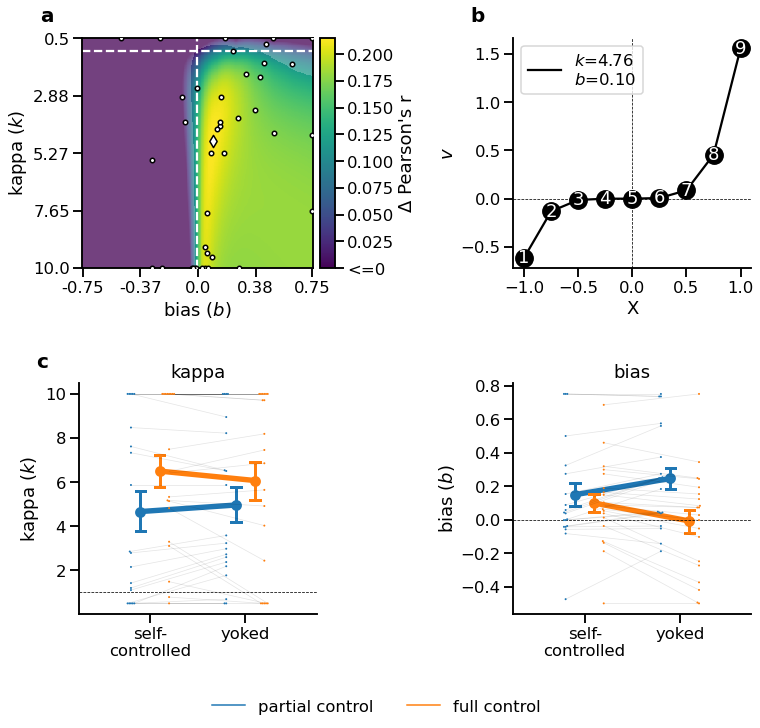

In [518]:
also_png = True
for ext in ["pdf", "png"]:
    if not also_png and ext == "png":
        continue

    fname = (
        f"fig4_nm_{model_to_use}_{corr_method}_b-{biases.max()}_k-{kappas.max()}.{ext}"
    )
    fname = os.path.join(plotdir, fname)

    dpi = 300 if ext == ".png" else None
    fig.savefig(fname, bbox_extra_artists=extra_artists, bbox_inches="tight", dpi=dpi)

fig